In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anhvuong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
data = pd.read_csv('spam_ham_dataset.csv')
data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [26]:
data.shape

(5171, 4)

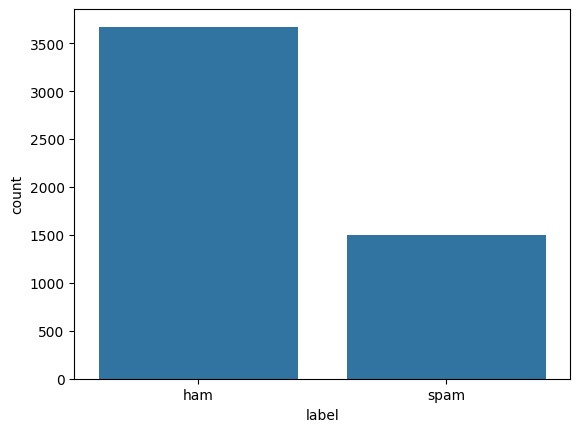

In [27]:
sns.countplot(x='label', data=data)
plt.show()

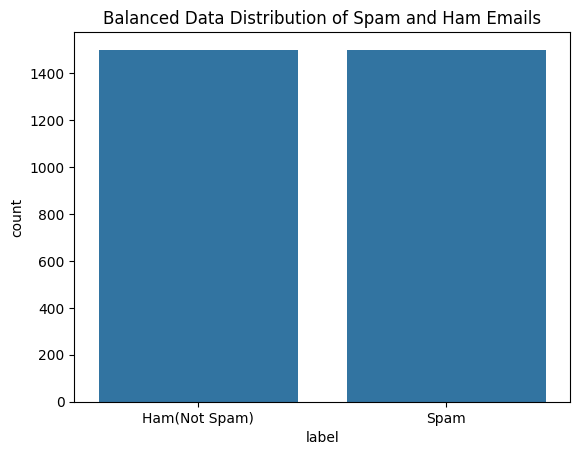

In [28]:
ham_msg = data[data['label'] == 'ham']
spam_msg = data[data['label'] == 'spam']

ham_msg_balanced = ham_msg.sample(n=len(spam_msg), random_state=42)

#Combine balanced data
balanced_data = pd.concat([ham_msg_balanced, spam_msg]).reset_index(drop=True)

#Visualize
sns.countplot(x='label', data=balanced_data)
plt.title("Balanced Data Distribution of Spam and Ham Emails")
plt.xticks(ticks=[0, 1], labels=['Ham(Not Spam)', 'Spam'])
plt.show()

In [29]:
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
balanced_data.head()


,Unnamed: 0,label,text,label_num
0,3444,ham,: conoco - big cowboy\r\ndarren :\r\ni ' m not...,0
1,2982,ham,: feb 01 prod : sale to teco gas processing\r\...,0
2,2711,ham,": california energy crisis\r\ncalifornia  , s...",0
3,3116,ham,: re : nom / actual volume for april 23 rd\r\n...,0
4,1314,ham,: eastrans nomination changes effective 8 / 2 ...,0


In [30]:
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

balanced_data['text'] = balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,conoco big cowboy\r\ndarren \r\ni m not sur...,0
1,2982,ham,feb 01 prod sale to teco gas processing\r\ns...,0
2,2711,ham,california energy crisis\r\ncalifornia  s p...,0
3,3116,ham,re nom actual volume for april 23 rd\r\nwe ...,0
4,1314,ham,eastrans nomination changes effective 8 2 0...,0


In [31]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    imp_words = []
    
    #Storing the important words
    for word in text.split():
        if word.lower() not in stop_words:
            imp_words.append(word)
    
    output = " ".join(imp_words)
    return output

balanced_data['text'] = balanced_data['text'].apply(lambda text:
remove_stopwords(text))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,conoco big cowboy darren sure help know else a...,0
1,2982,ham,feb 01 prod sale teco gas processing sale deal...,0
2,2711,ham,california energy crisis california  power cr...,0
3,3116,ham,nom actual volume april 23 rd agree eileen pon...,0
4,1314,ham,eastrans nomination changes effective 8 2 00 p...,0


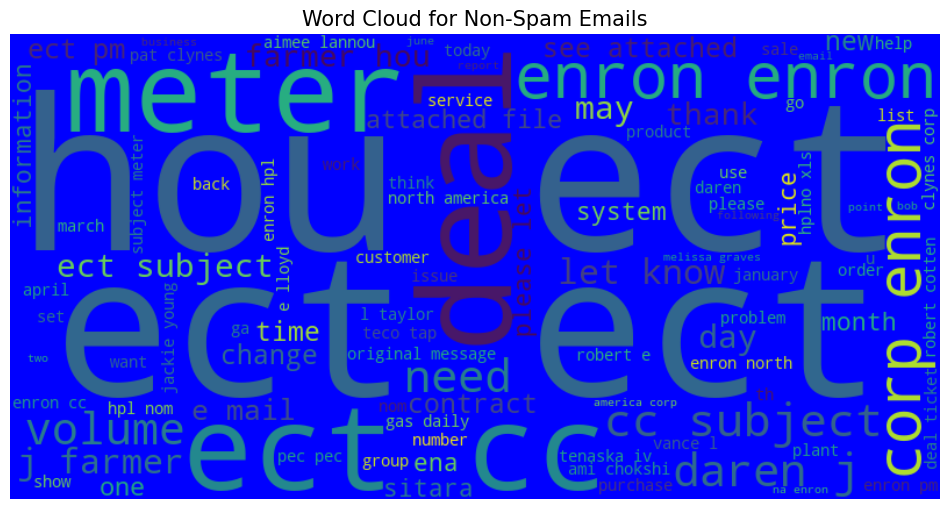

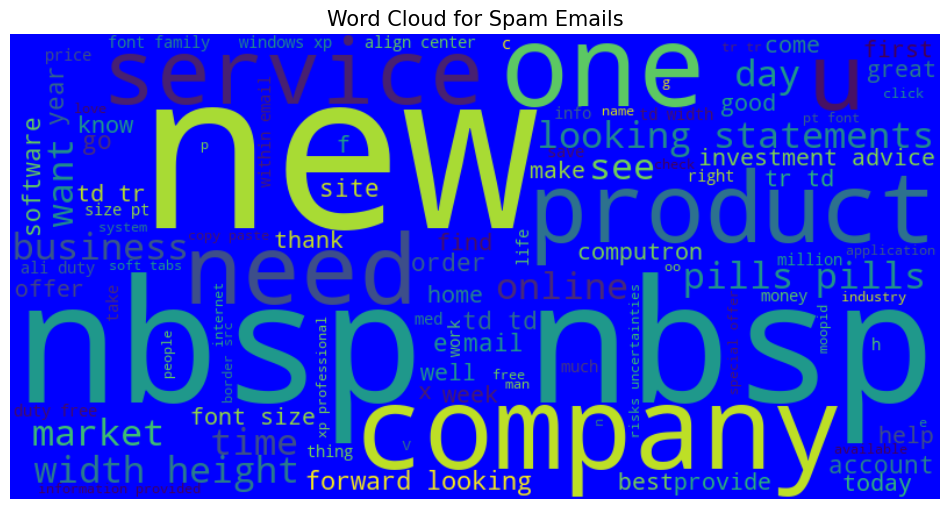

In [32]:
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data["text"])
    wc = WordCloud(background_color='blue', max_words=100, width= 800, height=400).generate(email_corpus)
    plt.figure(figsize=(12,10))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'Word Cloud for {typ} Emails', fontsize=15)
    plt.axis("off")
    plt.show()

plot_word_cloud(balanced_data[balanced_data['label'] == 'ham'], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['label'] == 'spam'], typ='Spam')

In [33]:
train_X, test_X, train_y, test_y = train_test_split(balanced_data['text'], balanced_data['label'], test_size=0.2, random_state=42)

Tokenizer = Tokenizer()
Tokenizer.fit_on_texts(train_X)

train_sequences = Tokenizer.texts_to_sequences(train_X)
test_sequences = Tokenizer.texts_to_sequences(test_X)

max_len = 100 # Maximum sequence length
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

train_y = (train_y == 'spam').astype(int)
test_y = (test_y == 'spam').astype(int)

In [34]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=len(Tokenizer.word_index) + 1, output_dim=32, input_length=max_len),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer
])

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [35]:
es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=0)

history = model.fit(train_sequences, train_y, validation_data=(test_sequences, test_y),
                    epochs=10, batch_size=32, callbacks=[es, lr])


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5431 - loss: 0.6906 - val_accuracy: 0.9083 - val_loss: 0.3973 - learning_rate: 0.0010
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9474 - loss: 0.2684 - val_accuracy: 0.9517 - val_loss: 0.1774 - learning_rate: 0.0010
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9602 - loss: 0.1527 - val_accuracy: 0.9617 - val_loss: 0.1559 - learning_rate: 0.0010
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9696 - loss: 0.1293 - val_accuracy: 0.9617 - val_loss: 0.1701 - learning_rate: 0.0010
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9587 - loss: 0.1717 - val_accuracy: 0.9583 - val_loss: 0.1706 - learning_rate: 0.0010
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9652 - loss: 0.1472 - val_accuracy: 0.9583 - val_loss: 0.1669 - learning_rate: 5.0000e-04


In [36]:
test_loss, test_accuracy = model.evaluate(test_sequences, test_y)
print(f"Test Loss:", test_loss)
print(f"Test Accuracy:", test_accuracy)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9603 - loss: 0.1620
Test Loss: 0.1559084802865982
Test Accuracy: 0.9616666436195374


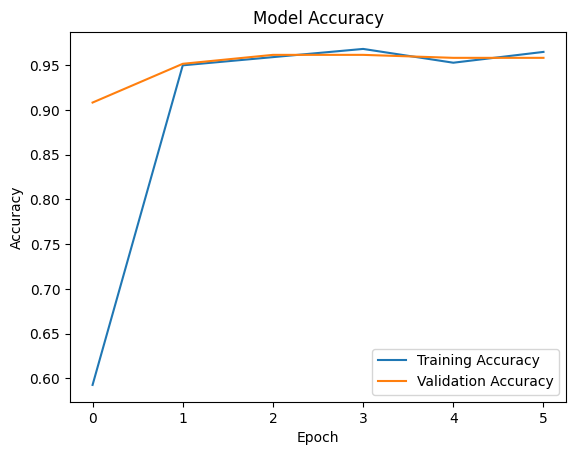

In [37]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

